# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [1]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [2]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [3]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [4]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i\sigma}X_{i+1\sigma} + y Y_{i\sigma} Y_{i+1\sigma} + z Z_{i\sigma} Z_{i+1\sigma}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [5]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [6]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [7]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [8]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [9]:
Blocks(1,2,3,2,2)['0,0']

[PauliOp(Pauli('II'), coeff=3.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('ZI'), coeff=3.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [10]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-10-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-10-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [11]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [12]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [13]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

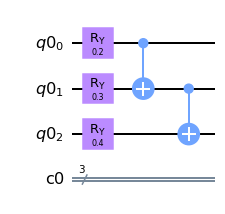

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [15]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

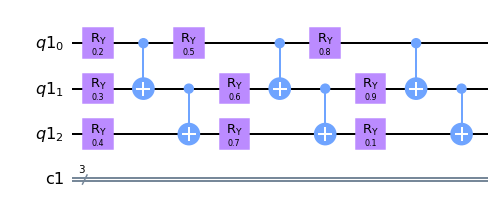

In [16]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [17]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

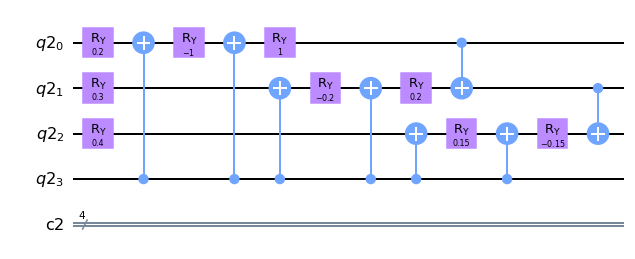

In [18]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [19]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [20]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

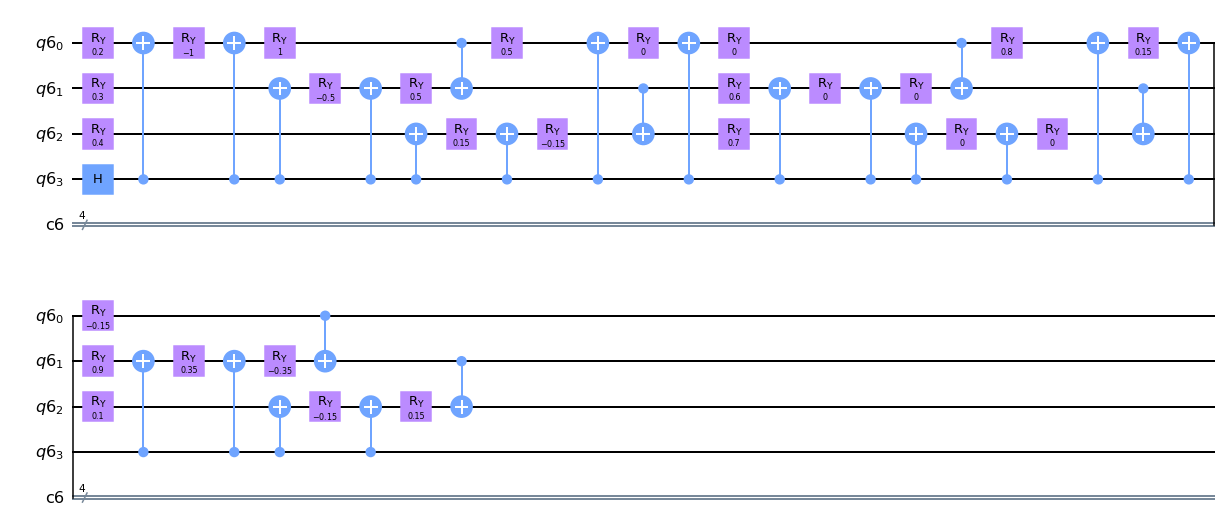

In [21]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [22]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(-0.2381742951601455+0j)
-0.2381742951601454
-0.244140625


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 
$$ <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = i<\psi^{a}|ZZ|\psi^{b}> - i<\psi^{b}|ZZ|\psi^{a}>  $$ 

$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> +  i <\psi^{ab}|Y\otimes ZZ|\psi^{ab}> = <\psi^{a}|ZZ|\psi^{b}> $$

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [23]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = np.sum(block).to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (7.778389592289885+0j)
simple: (7.778389592289887+0j)
matrix: 7.778389592289887
simulator: 8.04296875


In [24]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_px = measure_pauli('X' + p_label,psi,method = method)
        E_py = measure_pauli('Y' + p_label,psi,method = method)
        E += w*(E_px + 1j*E_py)/2
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = np.sum(block).to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',1/2*np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (0.4020509733039983+0j)
simple: (0.40205097330399836+0j)
matrix: (0.40205097330399836-8.109832250191573e-17j)
simulator: (0.3701171875-0.0078125j)


In [25]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = method)
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = method)
    return E
            
find_E(alpha,phi,blocks)

(5.726887817788551+0j)

In [26]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(5.726887817788552+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [27]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(7+0j)

# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [28]:
import copy

In [51]:
#beta = 0.602
beta = 0.201
A = 0
a = 0.03
gamma = 0.101
c = 0.2

beta_a = beta
A_a = A
a_a = a
gamma_a = gamma
c_a = c

def SPSA(k_max,method = 'simple',hold = False, seed = 'False'):
    #Initalization
    if seed == 'True': np.random.seed(0)
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        #print('k = ', k ,' E_f = ', E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [52]:
out = SPSA(1000,method = 'simple',hold = True, seed = 'True')

k= 0 c_k= 0.2 a_k= 0.03 g= 8.523911606253755 E_A= (7.905451899927731+0j) E_B= (4.4958872574262285+0j) E_f= 3.9089139657354917
k= 1 c_k= 0.1864772972873665 a_k= 0.02609842058125952 g= -0.18747858814419066 E_A= (3.8317137681102706+0j) E_B= (3.9016347689430306+0j) E_f= 3.9119414138975266
k= 2 c_k= 0.17899493787135265 a_k= 0.024055804328176503 g= -1.9734436033501834 E_A= (3.7003343423933184+0j) E_B= (4.406807172741887+0j) E_f= 3.8480242163028064
k= 3 c_k= 0.17386891201800433 a_k= 0.022704251894543687 g= 8.643081163168512 E_A= (5.469722096193794+0j) E_B= (2.4641958595469613+0j) E_f= 2.3240242307051897
k= 4 c_k= 0.16999416915812673 a_k= 0.021708423420009716 g= 5.943417205862126 E_A= (3.6800958080548276+0j) E_B= (1.6594032683135334+0j) E_f= 1.7829221171486678
k= 5 c_k= 0.1668924612118496 a_k= 0.02092728329257445 g= 8.133140090225277 E_A= (3.334864003203351+0j) E_B= (0.620144469126429+0j) E_f= 0.6060880331043336
k= 6 c_k= 0.16431419883627008 a_k= 0.020288808765737226 g= 7.410402006556096 E_A= 

k= 52 c_k= 0.1339300814134255 a_k= 0.013506468340629966 g= -1.462137658530033 E_A= (-10.090809717753615+0j) E_B= (-9.69916128646449+0j) E_f= -10.999662156788027
k= 53 c_k= 0.13367747261071303 a_k= 0.013455818144359654 g= -2.7369364676786057 E_A= (-10.530797985042307+0j) E_B= (-9.79906448565157+0j) E_f= -11.1038963964952
k= 54 c_k= 0.1334299625175472 a_k= 0.013406282112057749 g= 3.77759831558181 E_A= (-9.734127820705538+0j) E_B= (-10.742217424014399+0j) E_f= -11.116124200120284
k= 55 c_k= 0.13318735827857978 a_k= 0.0133578161353542 g= -2.380682411223194 E_A= (-10.366672253269492+0j) E_B= (-9.732518650767298+0j) E_f= -11.092280194553723
k= 56 c_k= 0.1329494776149124 a_k= 0.01331037860061991 g= -0.8627318216456357 E_A= (-10.243020271583998+0j) E_B= (-10.0136207815649+0j) E_f= -11.07918398334762
k= 57 c_k= 0.13271614807033782 a_k= 0.013263930206997074 g= -4.092743421909009 E_A= (-10.702516813199534+0j) E_B= (-9.61617052920758+0j) E_f= -11.084425317610211
k= 58 c_k= 0.13248720632325808 a_k=

k= 103 c_k= 0.12511507148736248 a_k= 0.011794989361800614 g= -3.8953494192579217 E_A= (-11.846878544631947+0j) E_B= (-10.872144702514525+0j) E_f= -12.391031165720834
k= 104 c_k= 0.12499420436933971 a_k= 0.011772323980601988 g= 1.862311661452393 E_A= (-11.217002034407278+0j) E_B= (-11.682558363229248+0j) E_f= -12.373469867611696
k= 105 c_k= 0.12487459803726274 a_k= 0.011749916377374242 g= -3.6456495482345304 E_A= (-11.882987282107528+0j) E_B= (-10.972489238266498+0j) E_f= -12.37266197796078
k= 106 c_k= 0.1247562276299998 a_k= 0.011727761229627638 g= 6.309889323612758 E_A= (-10.603996170749049+0j) E_B= (-12.178392148302526+0j) E_f= -12.460589118698111
k= 107 c_k= 0.12463906900325862 a_k= 0.011705853373214711 g= -3.745264600044519 E_A= (-11.949868473076814+0j) E_B= (-11.016255887235992+0j) E_f= -12.458822589050584
k= 108 c_k= 0.12452309870250361 a_k= 0.011684187796204918 g= -2.141855067756516 E_A= (-11.554434638306324+0j) E_B= (-11.02101377828892+0j) E_f= -12.497870060665207
k= 109 c_k= 0

k= 153 c_k= 0.12025147243640112 a_k= 0.010900077601103137 g= -1.6515747318484417 E_A= (-12.078131710274704+0j) E_B= (-11.680923123587645+0j) E_f= -12.609476343207863
k= 154 c_k= 0.12017288685647193 a_k= 0.010885906088509215 g= 2.407523787881375 E_A= (-11.498521970687527+0j) E_B= (-12.077160138218193+0j) E_f= -12.605272242647207
k= 155 c_k= 0.12009485751575995 a_k= 0.010871843959175927 g= 1.639534113964988 E_A= (-11.581650982347705+0j) E_B= (-11.975450213965411+0j) E_f= -12.596261207617205
k= 156 c_k= 0.12001737694913578 a_k= 0.010857889675722081 g= 1.7819468414336637 E_A= (-11.588113802751254+0j) E_B= (-12.015842974294586+0j) E_f= -12.582981110807705
k= 157 c_k= 0.11994043783840477 a_k= 0.010844041731992353 g= 0.8851849162792096 E_A= (-11.818825029591624+0j) E_B= (-12.031163962444584+0j) E_f= -12.60026577800596
k= 158 c_k= 0.1198640330085065 a_k= 0.010830298652230175 g= 1.4774610907803962 E_A= (-11.537854202591054+0j) E_B= (-11.892043092499225+0j) E_f= -12.585531276663604
k= 159 c_k= 0

k= 203 c_k= 0.11688461448161859 a_k= 0.010301147150814509 g= -3.566251284552822 E_A= (-12.28875391577193+0j) E_B= (-11.455074102692862+0j) E_f= -12.785804177420795
k= 204 c_k= 0.11682690076622317 a_k= 0.010291027260909314 g= -1.647762120485695 E_A= (-12.253774970901734+0j) E_B= (-11.868769087429087+0j) E_f= -12.782094366086989
k= 205 c_k= 0.11676949618672382 a_k= 0.010280966485792443 g= 4.3550543687520555 E_A= (-11.505023463230637+0j) E_B= (-12.522098472240573+0j) E_f= -12.821026865485134
k= 206 c_k= 0.11671239759862044 a_k= 0.010270964195686606 g= 0.5000641441906287 E_A= (-11.629128035780743+0j) E_B= (-11.745855406223924+0j) E_f= -12.813334103233114
k= 207 c_k= 0.11665560190439503 a_k= 0.010261019770525142 g= -2.8459082511643383 E_A= (-12.46378155448354+0j) E_B= (-11.79979927447502+0j) E_f= -12.824253945804857
k= 208 c_k= 0.11659910605258784 a_k= 0.010251132599756446 g= -0.564647148538861 E_A= (-12.156988714524594+0j) E_B= (-12.025314009015046+0j) E_f= -12.818763499253134
k= 209 c_k= 

k= 253 c_k= 0.11432515274230863 a_k= 0.009857111693337027 g= -1.5191151828475031 E_A= (-12.213943533677112+0j) E_B= (-11.86659738305271+0j) E_f= -12.939024864284624
k= 254 c_k= 0.11427979099629479 a_k= 0.009849329768731513 g= -0.7577897906097422 E_A= (-12.299938621838438+0j) E_B= (-12.126738504058423+0j) E_f= -12.949691890914744
k= 255 c_k= 0.11423462468485453 a_k= 0.009841584409439707 g= 0.5305655146249741 E_A= (-12.219542521521724+0j) E_B= (-12.340760426389545+0j) E_f= -12.944665438734587
k= 256 c_k= 0.11418965220748623 a_k= 0.009833875301820292 g= 1.54591382537988 E_A= (-12.190840439036327+0j) E_B= (-12.543895163162073+0j) E_f= -12.948211430821056
k= 257 c_k= 0.11414487198295892 a_k= 0.009826202136129352 g= 0.8697459276116561 E_A= (-11.92993006443878+0j) E_B= (-12.128484139568645+0j) E_f= -12.960240130406927
k= 258 c_k= 0.11410028244900672 a_k= 0.00981856460645705 g= 1.2127174708887025 E_A= (-11.850047553285165+0j) E_B= (-12.126790365203657+0j) E_f= -12.95308697828144
k= 259 c_k= 0.

k= 303 c_k= 0.11226897657776405 a_k= 0.009507441556238732 g= 0.6030323506936693 E_A= (-12.20721581711566+0j) E_B= (-12.342619466826983+0j) E_f= -13.057253333317735
k= 304 c_k= 0.11223174407701314 a_k= 0.00950116777336444 g= -0.9154636192141629 E_A= (-12.37182233647209+0j) E_B= (-12.166334179225169+0j) E_f= -13.05037011893895
k= 305 c_k= 0.11219464573756313 a_k= 0.009494918646291033 g= 2.088173911284945 E_A= (-12.105815538587311+0j) E_B= (-12.574379403017383+0j) E_f= -13.097215472900526
k= 306 c_k= 0.11215768063991265 a_k= 0.009488693998020952 g= 0.24211913001574217 E_A= (-12.276984074462701+0j) E_B= (-12.33129511458494+0j) E_f= -13.094265999443506
k= 307 c_k= 0.11212084787383166 a_k= 0.009482493653398535 g= -0.24329967783925133 E_A= (-12.23373645146116+0j) E_B= (-12.179178519127627+0j) E_f= -13.091888633884503
k= 308 c_k= 0.11208414653823812 a_k= 0.009476317439084959 g= 0.5372743617424612 E_A= (-12.195606594865989+0j) E_B= (-12.31604647145155+0j) E_f= -13.100766352514905
k= 309 c_k= 0.

k= 353 c_k= 0.11055557971185336 a_k= 0.009220863627630723 g= 1.7560265287924408 E_A= (-12.423480198889028+0j) E_B= (-12.811757260649111+0j) E_f= -13.296834784047343
k= 354 c_k= 0.1105240859729397 a_k= 0.009215636915406195 g= -0.28221862754861626 E_A= (-12.510964122330487+0j) E_B= (-12.44858021062179+0j) E_f= -13.295521614487328
k= 355 c_k= 0.11049268975786523 a_k= 0.009210427855824644 g= -0.6384494586554197 E_A= (-12.59097413838007+0j) E_B= (-12.449886142457489+0j) E_f= -13.291308473321722
k= 356 c_k= 0.11046139049196252 a_k= 0.00920523633993072 g= -0.8180710518441087 E_A= (-12.82453380664611+0j) E_B= (-12.643803274830265+0j) E_f= -13.2871760132262
k= 357 c_k= 0.11043018760554815 a_k= 0.009200062259744369 g= 1.9807555736055262 E_A= (-12.603736060111451+0j) E_B= (-13.041206479299438+0j) E_f= -13.294772607287685
k= 358 c_k= 0.11039908053386581 a_k= 0.009194905508249411 g= 0.08504850033902375 E_A= (-12.611998866630923+0j) E_B= (-12.630777419107348+0j) E_f= -13.295313377217466
k= 359 c_k= 

k= 403 c_k= 0.10909013464597506 a_k= 0.008979219751621964 g= 0.35405913563077934 E_A= (-12.97276673928661+0j) E_B= (-13.05001545684381+0j) E_f= -13.552077139408393
k= 404 c_k= 0.10906289921021875 a_k= 0.008974758995760482 g= -2.3897943508219393 E_A= (-13.134010685926054+0j) E_B= (-12.612734885092367+0j) E_f= -13.558145149325494
k= 405 c_k= 0.10903573771406674 a_k= 0.008970311448394969 g= 0.04744265669188808 E_A= (-12.84819033612868+0j) E_B= (-12.85853622627171+0j) E_f= -13.55833822654094
k= 406 c_k= 0.1090086497754083 a_k= 0.008965877038025418 g= 1.1004199831639252 E_A= (-12.669541728662434+0j) E_B= (-12.909452321763588+0j) E_f= -13.55121075182535
k= 407 c_k= 0.10898163501504007 a_k= 0.00896145569371334 g= -0.7526108129593401 E_A= (-13.079532566626725+0j) E_B= (-12.91549105277411+0j) E_f= -13.561747773887735
k= 408 c_k= 0.10895469305663695 a_k= 0.00895704734507598 g= -0.6647070901656209 E_A= (-13.132945581899298+0j) E_B= (-12.988099667936167+0j) E_f= -13.570356111599857
k= 409 c_k= 0.1

k= 453 c_k= 0.10781206253228215 a_k= 0.008771079113782165 g= -1.1403695694884377 E_A= (-13.248565333596181+0j) E_B= (-13.002674142924983+0j) E_f= -13.892654433255911
k= 454 c_k= 0.10778810694832996 a_k= 0.008767201010735205 g= 2.687663230921668 E_A= (-12.980581424966811+0j) E_B= (-13.559977688518169+0j) E_f= -13.903274132054468
k= 455 c_k= 0.10776420926162071 a_k= 0.008763333130690748 g= 0.4233274534749396 E_A= (-13.295831362735742+0j) E_B= (-13.387070459300666+0j) E_f= -13.900689845926493
k= 456 c_k= 0.10774036920571672 a_k= 0.008759475424369716 g= 1.525676660609908 E_A= (-13.196826603367512+0j) E_B= (-13.525580536772825+0j) E_f= -13.901950737735307
k= 457 c_k= 0.1077165865159861 a_k= 0.008755627842837751 g= 2.7404694409989716 E_A= (-12.962418264195144+0j) E_B= (-13.552806291466707+0j) E_f= -13.965437095912911
k= 458 c_k= 0.10769286092958656 a_k= 0.008751790337502046 g= 0.10530626280226706 E_A= (-13.456963263567976+0j) E_B= (-13.479644728997934+0j) E_f= -13.966405032606712
k= 459 c_k=

k= 503 c_k= 0.10668036955712382 a_k= 0.008588804490781457 g= -0.0007210161696243867 E_A= (-13.622100738088989+0j) E_B= (-13.621946901546124+0j) E_f= -14.299260431202702
k= 504 c_k= 0.10665901446815508 a_k= 0.008585383268953629 g= 2.3727941292559 E_A= (-13.523893777383062+0j) E_B= (-14.030053544107579+0j) E_f= -14.339715459063985
k= 505 c_k= 0.10663770588683978 a_k= 0.0085819701738776 g= 2.7234496746965604 E_A= (-13.494793690756502+0j) E_B= (-14.075638541572305+0j) E_f= -14.387746071226502
k= 506 c_k= 0.10661644362027974 a_k= 0.008578565170245479 g= 2.271550273416744 E_A= (-13.317259441101614+0j) E_B= (-13.801628664414348+0j) E_f= -14.392175959980504
k= 507 c_k= 0.10659522747675534 a_k= 0.008575168222972033 g= -1.6440873705311247 E_A= (-14.075413121629328+0j) E_B= (-13.724909387122477+0j) E_f= -14.411258762669142
k= 508 c_k= 0.10657405726571603 a_k= 0.008571779297192843 g= 0.9720027648391019 E_A= (-13.668008117719651+0j) E_B= (-13.875188674364445+0j) E_f= -14.426956553199025
k= 509 c_k=

k= 553 c_k= 0.10566605887135892 a_k= 0.00842705429395164 g= -1.7772082837140992 E_A= (-13.99695381322758+0j) E_B= (-13.62137262296038+0j) E_f= -14.57295329134605
k= 554 c_k= 0.10564681396073539 a_k= 0.00842400013450978 g= -1.0655473106714488 E_A= (-14.088248165396612+0j) E_B= (-13.863104808402875+0j) E_f= -14.574648977715128
k= 555 c_k= 0.10562760719004227 a_k= 0.00842095257701884 g= 0.32930145581232323 E_A= (-13.887996186617007+0j) E_B= (-13.957562836260314+0j) E_f= -14.575841212837103
k= 556 c_k= 0.10560843841529971 a_k= 0.008417911595372297 g= -0.43511718838600344 E_A= (-13.943519748608699+0j) E_B= (-13.851615655022496+0j) E_f= -14.5752786464251
k= 557 c_k= 0.10558930749332869 a_k= 0.008414877163613497 g= 1.1938818607581156 E_A= (-13.720148208299063+0j) E_B= (-13.972270526111656+0j) E_f= -14.569163749177521
k= 558 c_k= 0.10557021428174505 a_k= 0.00841184925593453 g= 0.6643752339251503 E_A= (-13.866588579660204+0j) E_B= (-14.00686505127813+0j) E_f= -14.565404146211364
k= 559 c_k= 0.1

k= 603 c_k= 0.10474788551211245 a_k= 0.008281954306293702 g= 0.951493749119257 E_A= (-13.960766572905252+0j) E_B= (-14.16010048950172+0j) E_f= -14.748926370754106
k= 604 c_k= 0.10473038566913068 a_k= 0.00827920096225943 g= 1.4883622901036704 E_A= (-13.891645044108039+0j) E_B= (-14.203398557423935+0j) E_f= -14.744950094217728
k= 605 c_k= 0.10471291764403264 a_k= 0.008276453078536878 g= 0.5867998137433855 E_A= (-13.961154856974556+0j) E_B= (-14.084045898114645+0j) E_f= -14.746395050611985
k= 606 c_k= 0.10469548132660587 a_k= 0.008273710635313744 g= -1.5106334536093675 E_A= (-14.278081158420045+0j) E_B= (-13.961768165352634+0j) E_f= -14.74370153217625
k= 607 c_k= 0.10467807660720045 a_k= 0.0082709736128821 g= -0.15716700428756428 E_A= (-14.105325690227389+0j) E_B= (-14.072421810797513+0j) E_f= -14.744105945830608
k= 608 c_k= 0.10466070337672526 a_k= 0.008268241991637676 g= 0.4833875186089798 E_A= (-13.981532511707341+0j) E_B= (-14.082715867109632+0j) E_f= -14.74530519975771
k= 609 c_k= 0.

k= 653 c_k= 0.10390983210093452 a_k= 0.008150610268494049 g= 0.30910664386878645 E_A= (-14.050313011213559+0j) E_B= (-14.114551450144937+0j) E_f= -14.76741261791327
k= 654 c_k= 0.10389379835707084 a_k= 0.008148107561927605 g= 0.7020908434185841 E_A= (-13.851953702865828+0j) E_B= (-13.99783947189478+0j) E_f= -14.767078252607666
k= 655 c_k= 0.10387779154196164 a_k= 0.00814560944009167 g= 0.5163612950045258 E_A= (-14.07575892774024+0j) E_B= (-14.183035869665876+0j) E_f= -14.7664311614793
k= 656 c_k= 0.10386181156943329 a_k= 0.008143115887617689 g= -1.6051332562116973 E_A= (-14.20882013078313+0j) E_B= (-13.875396035182149+0j) E_f= -14.768278484238971
k= 657 c_k= 0.10384585835371854 a_k= 0.008140626889211926 g= 0.11339843467138536 E_A= (-14.135579762413009+0j) E_B= (-14.159131677981845+0j) E_f= -14.768160340570285
k= 658 c_k= 0.10382993180945402 a_k= 0.008138142429654974 g= -0.8720503763247872 E_A= (-14.184684246647326+0j) E_B= (-14.003594384430903+0j) E_f= -14.773085739451416
k= 659 c_k= 0

k= 703 c_k= 0.10313953215320047 a_k= 0.008030806285525735 g= 0.26727111384590957 E_A= (-14.117618134887325+0j) E_B= (-14.172750570167588+0j) E_f= -14.768350139780798
k= 704 c_k= 0.10312474670562992 a_k= 0.008028515352829219 g= -0.7602514768650063 E_A= (-14.166495926011365+0j) E_B= (-14.009694444042795+0j) E_f= -14.770662515155276
k= 705 c_k= 0.10310998433051545 a_k= 0.00802622831952192 g= -0.16538201448738687 E_A= (-14.267488563577913+0j) E_B= (-14.233383489733226+0j) E_f= -14.771039370391682
k= 706 c_k= 0.10309524495924871 a_k= 0.008023945173457564 g= -0.6552772216359746 E_A= (-14.292388765385828+0j) E_B= (-14.157276834024275+0j) E_f= -14.778725765270014
k= 707 c_k= 0.1030805285235221 a_k= 0.008021665902544833 g= 0.7587862130482251 E_A= (-14.016019063181824+0j) E_B= (-14.17245123093657+0j) E_f= -14.78090795274453
k= 708 c_k= 0.1030658349553269 a_k= 0.008019390494747024 g= 0.9530193406357822 E_A= (-14.117229344021506+0j) E_B= (-14.31367681216391+0j) E_f= -14.78398105244269
k= 709 c_k= 

k= 753 c_k= 0.10242724456054311 a_k= 0.007920810335592431 g= -0.06063658123185909 E_A= (-14.306240869622933+0j) E_B= (-14.29381919375263+0j) E_f= -14.79643271493018
k= 754 c_k= 0.10241353420822148 a_k= 0.007918700499856744 g= 1.1669024254404718 E_A= (-14.062163829723533+0j) E_B= (-14.301177032654541+0j) E_f= -14.802395108663514
k= 755 c_k= 0.10239984383484511 a_k= 0.007916594017630443 g= -1.0768046723111402 E_A= (-14.300424921642188+0j) E_B= (-14.079895661071603+0j) E_f= -14.797825787596603
k= 756 c_k= 0.10238617338493088 a_k= 0.00791449087915795 g= 0.5660226797050939 E_A= (-14.001180429695998+0j) E_B= (-14.117086222144176+0j) E_f= -14.79959496421636
k= 757 c_k= 0.10237252280322276 a_k= 0.007912391074724901 g= 0.11587923265555596 E_A= (-14.07104810774413+0j) E_B= (-14.094773806519031+0j) E_f= -14.798730538672233
k= 758 c_k= 0.10235889203469066 a_k= 0.007910294594657929 g= 0.7167970312265192 E_A= (-14.227025628470738+0j) E_B= (-14.373766728330942+0j) E_f= -14.795979452186433
k= 759 c_k=

k= 803 c_k= 0.10176516351166778 a_k= 0.007819244421184582 g= -0.7340285059417575 E_A= (-14.336986150479868+0j) E_B= (-14.187589088621092+0j) E_f= -14.812749082655985
k= 804 c_k= 0.10175238832499586 a_k= 0.007817291068778237 g= -1.2035755063014346 E_A= (-14.324499622889585+0j) E_B= (-14.07956625829831+0j) E_f= -14.820771683843317
k= 805 c_k= 0.10173963059903428 a_k= 0.007815340628456445 g= 0.3562136635842945 E_A= (-14.24446152900387+0j) E_B= (-14.316943622098659+0j) E_f= -14.8186466808882
k= 806 c_k= 0.10172689028829925 a_k= 0.00781339309227289 g= -0.5075163885901628 E_A= (-14.272575830347158+0j) E_B= (-14.169319702383907+0j) E_f= -14.819229897234239
k= 807 c_k= 0.10171416734748165 a_k= 0.007811448452312757 g= 0.078867006344 E_A= (-14.266271259653239+0j) E_B= (-14.282315043416176+0j) E_f= -14.818560280709615
k= 808 c_k= 0.10170146173144613 a_k= 0.007809506700692559 g= -0.4900577349301064 E_A= (-14.275526606709509+0j) E_B= (-14.175847430759122+0j) E_f= -14.818301154942175
k= 809 c_k= 0.1

k= 853 c_k= 0.10114694049765113 a_k= 0.007724995279461308 g= 1.8612703665497474 E_A= (-14.064363043411886+0j) E_B= (-14.440886649442783+0j) E_f= -14.825424163179383
k= 854 c_k= 0.1011349858593422 a_k= 0.007723178378791109 g= 1.526770356391082 E_A= (-14.228381493119945+0j) E_B= (-14.537201289928095+0j) E_f= -14.82735435721872
k= 855 c_k= 0.1011230466053497 a_k= 0.007721364028491255 g= 0.10147693648414707 E_A= (-14.25869813686482+0j) E_B= (-14.27922145081973+0j) E_f= -14.827294302692277
k= 856 c_k= 0.101111122697938 a_k= 0.007719552222008671 g= -1.7980181977540517 E_A= (-14.360143592104562+0j) E_B= (-13.996544314892091+0j) E_f= -14.823674950870851
k= 857 c_k= 0.10109921409950795 a_k= 0.007717742952814742 g= -0.36200073954658357 E_A= (-14.311702160177644+0j) E_B= (-14.238506179634443+0j) E_f= -14.823938223755915
k= 858 c_k= 0.1010873207725962 a_k= 0.007715936214405193 g= -2.1482876485771563 E_A= (-14.458624664639972+0j) E_B= (-14.024295379352921+0j) E_f= -14.828142928981247
k= 859 c_k= 0.

k= 903 c_k= 0.10056734485550804 a_k= 0.007637151399810239 g= 1.7898495651981259 E_A= (-14.133176289811228+0j) E_B= (-14.49317712673675+0j) E_f= -14.844439307118156
k= 904 c_k= 0.10055611573910778 a_k= 0.007635454443439566 g= -1.9033429358142786 E_A= (-14.49794479809091+0j) E_B= (-14.115159253001002+0j) E_f= -14.845757557114057
k= 905 c_k= 0.10054490027546298 a_k= 0.0076337597375589995 g= 0.6144171725272827 E_A= (-14.199481427055126+0j) E_B= (-14.323034453733701+0j) E_f= -14.842394480596994
k= 906 c_k= 0.10053369843293233 a_k= 0.0076320672767049074 g= 0.4291832753544182 E_A= (-14.22069307043161+0j) E_B= (-14.306987834385488+0j) E_f= -14.846117586166176
k= 907 c_k= 0.10052251017998262 a_k= 0.007630377055432932 g= -0.267917918489382 E_A= (-14.210612007336923+0j) E_B= (-14.156748443959426+0j) E_f= -14.846083539059258
k= 908 c_k= 0.10051133548518829 a_k= 0.007628689068317892 g= 1.3736360721777088 E_A= (-14.172432826030027+0j) E_B= (-14.448564818200447+0j) E_f= -14.843699253176725
k= 909 c_k

k= 953 c_k= 0.10002201739784017 a_k= 0.007554957601280271 g= -0.5612266532742722 E_A= (-14.352453145694229+0j) E_B= (-14.240183101538367+0j) E_f= -14.850906072664941
k= 954 c_k= 0.10001143417079063 a_k= 0.007553366834659963 g= 0.21198398830163412 E_A= (-14.163866037236353+0j) E_B= (-14.206267682618934+0j) E_f= -14.851146402511327
k= 955 c_k= 0.1000008631379004 a_k= 0.0075517780673176145 g= -0.37924887341444136 E_A= (-14.269971021109829+0j) E_B= (-14.194120591738788+0j) E_f= -14.851814728697082
k= 956 c_k= 0.09999030427238575 a_k= 0.007550191294653174 g= -1.1296061357974216 E_A= (-14.435198826933716+0j) E_B= (-14.20929950448104+0j) E_f= -14.850850179622121
k= 957 c_k= 0.09997975754754977 a_k= 0.007548606512081966 g= 0.4522392947801517 E_A= (-14.33251918949027+0j) E_B= (-14.422948739581459+0j) E_f= -14.850819867961146
k= 958 c_k= 0.09996922293678188 a_k= 0.007547023715034625 g= 0.1432615021352227 E_A= (-14.278055115400488+0j) E_B= (-14.306698597490916+0j) E_f= -14.850060937941644
k= 959 

In [53]:
e,ys = np.linalg.eig(H_complete)

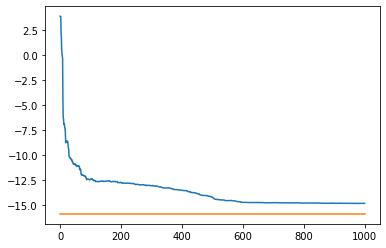

In [54]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [55]:
import pickle

file_to_store = open("VQE_ByQubit"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [56]:
import pickle

file_to_read = open("VQE_ByQubit"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_x_"+str(x)+"_y_"+str(y)+"_z_"+str(z)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

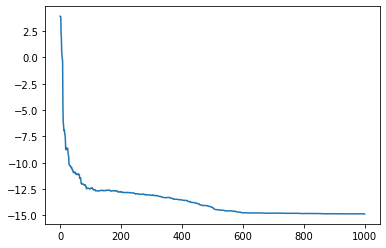

In [57]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [58]:
a

0.03